# Conformal prediction for regression

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import clone

from mapie.regression import MapieRegressor

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

In [2]:
# paramters that can be tweaked
random_state = 42
np.random.seed(random_state)
epsilon = 0.05
mu, sigma, n_samples, noise = 0, 2, 500, .5

# Used for plotting the target function
X_general = np.arange(mu - 3*sigma, mu + 3*sigma, step = sigma/20)
norm_quantile = sps.norm.ppf(1 - epsilon) 


##### Jupyter Book auxiliary########
from myst_nb import glue
glue("mu",mu, display=False) # makes the vairble mu abailable in markdown cell with {glue:}`mu`
glue("sigma",sigma, display=False)
glue("noise", noise, display=False)
###################################



def are_both_intervals_equal(interval1,interval2):
    print("Are both inervals equal?")
    if np.all(interval1 == interval2):
        print("Yes, both are equal!")
    else:
        print("No, both are not equal!")

def calculate_quantile(scores, epsilon, method="higher", axis=0):
    if len(scores.shape) == 1:
        n, = scores.shape
    else:
        _,n = scores.shape
    return np.quantile(
        scores,
        axis=axis,
        q=((n + 1) * (1 - epsilon)) / n,
        method=method,
    )

def target_function(X):
    return X * np.sin(X)**2

def create_regression_data(mu,sigma, n_samples, noise):
    X_train = np.random.normal(mu,sigma,n_samples).reshape(-1,1)
    X_test = np.arange(mu - 3*sigma, mu + 3*sigma, sigma/10).reshape(-1,1)
    
    y_train = target_function(X_train) + np.random.normal(0,
                                                          noise,
                                                          X_train.shape[0])[:,None]
    y_test = target_function(X_test) + np.random.normal(0,
                                                        noise,
                                                        X_test.shape[0])[:,None]

    return (
        X_train,
        X_test,
        y_train.ravel(),
        y_test.ravel()
    )
    
def get_coverage(true_ground, interval):
    coverage = 0
    for i, inter in enumerate(interval):
        current_value = true_ground[i]
        coverage += inter[0] <= current_value <= inter[1]
    coverage = coverage / len(true_ground)
    return coverage

def plot_data(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred=None,              
    y_pred_interval=None,
    method=None):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(w=12,h=5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # plot the true relationship with confidence intervals
    ax.plot(
        X_general, target_function(X_general), color="gray", ls="-", label="ground_truth"
    )
    ax.plot(X_general, target_function(X_general) - norm_quantile * noise, color="gray", ls="--", label="95% confidence interval of ground_truth")
    ax.plot(X_general, target_function(X_general) + norm_quantile * noise, color="gray", ls="--")

    if y_pred is not None and y_pred_interval is not None:
        # plot the prediction plus the interval
        ax.scatter(X_test,y_pred,color="aqua", label="prediction")
        ax.fill_between(X_test.ravel(), y_pred_interval[:,0].ravel(), y_pred_interval[:,1].ravel(), alpha=.4, label="prediction_coverage")

    # plot the data points
    ax.scatter(X_train, y_train, color="green", label="train data", alpha=.3)
    ax.scatter(X_test, y_test, color="red", label="test data")

    # set title
    if method != None:
        ax.set_title(f"Visualization of \"{method}\" having coverage = {round(get_coverage(y_test,y_pred_interval),2)}")
    else:
        ax.set_title(f"Visualization of data")
    ax.legend(loc="upper center")
    
    plt.show()


<div align="justify">

We now discuss Conformal prediction applied to regression tasks. We recommend reading the Chapter on [Conformal Classification](../chapter-conformel_classification/intro) as it covers the general idea. Regression is done through inductive conformal prediction which can be briefly described in four steps:

1. Divide the $x_1, \dots, x_n$ data points into $x_1, \dots, x_k$ training points and $x_{k+1}, \dots, x_{k+l-1}, x_{n}$ validation points such that $n = k + l$.
2. Train a arbitrary machine learning model on the  training set.
3. Calculate the non-conformity scores based on the calibration set.
4. Based on these value create a prediction interval for each new observation $x_{n+1}$.

The non-conformity function $f$ can be seen as the ''weirdness' of a label $y$ given the features $x$.
For the non-conformity function $f$ we use the *absolute residual score* one of the most commonly used non-conformity score functions:

$$
    f_h(x,y) = | y - h(x) |
$$

where $h$ is the underlying machine learning model we use.\

</div>

In [3]:
def absolute_residual_score(model,X,y):
    return np.abs(y - model.predict(X))

<div align="justify">

There are different ways of calculating the non-conformity scores and prediction intervals namely [Split](content:split),[Jackknife](content:jackknife) , [Jackknife+](content:jackknife_plus) and [Jackknife+_CV](content:jackknife_plus_cv) which we will present. \
We apply these methods to synthetic data, with features X being drawn from a Gaussian distribution with parameters $\mu = $ {glue:}`mu`, $\sigma=$ {glue:}`sigma`.
The relationship between the X values and target y is described by the function $x \mapsto x\sin(x)^2$.
Noise was added to y drawn from a Gaussian distribution with $\mu=0$ and $\sigma=${glue:}`noise`.

</div>

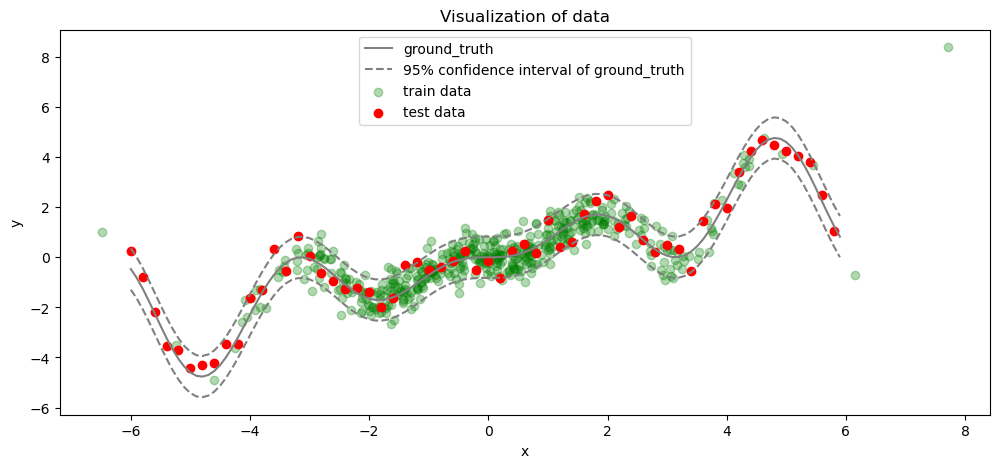

In [4]:
X_train,X_test,y_train,y_test = create_regression_data(mu,
                                                       sigma,
                                                       n_samples,
                                                       noise)
plot_data(X_train,X_test,y_train,y_test)

(content:split)=
## Split Method

<div align="justify">

This method uses the general inductive conformal prediction with only a single train/validation split.
It can be described by the following steps

1. Split the $n$ training data points into $k$ proper training and $l$ validation points and fit a model $\hat{h}$ on the training data.
2. Given $i = l, l+1, \dots, l+k-1, n$ validation points calculate the non-conformity scores $\alpha_i = f_{\hat{h}}(y_i, x_i)$.
3. Calculate the Quantile $ q_{split} = \lceil (1-\epsilon)*(l+1)\rceil \text{-Quantile of the sequence }(\alpha_{l}, \, \alpha_{l+1}, \ldots , \alpha_{n})$ for a predefined significance level $\epsilon$.
4. Build the prediction interval $Y_\epsilon$ for a new data point $x_{n+1}$:

$$
    Y_\epsilon = [\hat{h}(X_{n+1} - q_{split} \ , \ \hat h(x_{n+1})  + q_{split})]
$$

Given the above data, we firstly split the training into proper training and validation data.

</div>

In [5]:
X_train_prefit,X_val,y_train_prefit,y_val = train_test_split(X_train,y_train,
                                               train_size=0.8,
                                               random_state=random_state)

In the next step we fit an arbitrary machine learning algorithm to the training data.
Here we will use the [GradienBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html).

In [6]:
base_model = GradientBoostingRegressor(
    loss="squared_error",
    random_state=random_state
)  # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html
base_model.fit(X_train_prefit, y_train_prefit)


GradientBoostingRegressor(random_state=42)

Then we apply the non-conformity function $f$ to the validation dataset.

In [7]:
# construct the sequence of residuals
split_non_conformity_scores = absolute_residual_score(model=base_model,X=X_val,y=y_val)
split_non_conformity_scores

array([1.17621188e+00, 1.29941504e-01, 2.19041871e-01, 2.19637592e-02,
       8.65203580e-02, 7.72014317e-01, 3.68429832e-01, 7.22305073e-01,
       7.92107736e-01, 1.36845459e-01, 6.74883979e-01, 5.45870255e-01,
       8.71455367e-01, 1.82357056e-01, 4.50544064e-01, 5.32927336e-01,
       4.12196792e-01, 4.10194193e-01, 4.09962030e-01, 3.39198452e-01,
       1.08439456e-01, 1.04735050e+00, 1.03149838e-01, 4.90559969e-01,
       1.44895677e-01, 6.10784086e-01, 2.05508173e-01, 1.84123284e-01,
       5.13777762e-01, 2.01735407e-01, 9.11415896e-01, 5.53804262e-01,
       5.91165071e-01, 1.59038518e-01, 7.18983939e-01, 4.54037720e-01,
       1.29669969e+00, 1.51941944e-01, 8.92657129e+00, 2.27890354e-01,
       1.14714162e-01, 2.00646787e-01, 8.20624163e-01, 1.10063611e+00,
       8.20420804e-01, 3.87726955e-01, 4.07553094e-01, 2.10098109e-01,
       6.14708774e-02, 3.53782090e-01, 1.48828689e-01, 4.45750268e-01,
       7.42418761e-01, 5.83629052e-01, 5.07656121e-01, 8.08408140e-02,
      

Now we must calculate the $\lceil (1-\epsilon)*(l+1)\rceil$ Quantile on $\alpha_{l}, \, \alpha_{l+1}, \ldots , \alpha_{n}$.

In [8]:
split_quantile = calculate_quantile(split_non_conformity_scores,epsilon)
split_quantile

1.1762118765177787

In [9]:
def output_mean_interval_width(intervals):
    interval_widths = intervals[:,1] - intervals[:,0]
    print("Mean interval width: ", np.mean(interval_widths))

def get_prediction_interval_through_quantile(predictions, quantile):
    
    prediction_lower = (predictions - quantile).reshape(-1,1)
    prediction_higher = (predictions + quantile).reshape(-1,1)

    prediction_interval = np.concatenate((prediction_lower,prediction_higher),axis=1)
    return predictions, prediction_interval



split_prediction, split_interval = get_prediction_interval_through_quantile(
    predictions=base_model.predict(X_test), 
    quantile=split_quantile
)
print(split_interval[:2])
output_mean_interval_width(split_interval)

[[-4.73059586 -2.37817211]
 [-4.73059586 -2.37817211]]
Mean interval width:  2.352423753035558


<div align="justify">


An equal approach is firstly adding/subtracting the non-conformity scores $\alpha_{l}, \, \alpha_{l+1}, \ldots , \alpha_{n}$ from the predictions and then computing the upper bound $q_{l,\epsilon}^+$ and $q_{l,\epsilon}^-$ which are calculated as follows:

$$
    q_{m,\epsilon}^{+}(v_i) = \lceil (1-\epsilon)*(m+1)\rceil \text{-Quantile of the sequence }(v_1, v_2, \ldots , v_m)
$$

$$
    q_{m,\epsilon}^{-}(v_i) = \lfloor \epsilon*(m+1)\rfloor \text{-Quantile of the sequence }(v_1, v_2, \ldots , v_m) = -q_{n,\epsilon}^{+}(-v_i)
$$

The corresponding prediction interval $Y_\epsilon$ for a new data point $x_{n+1}$ would then be:

$$
    Y_\epsilon = [q_{l,\epsilon}^{-}(\hat{h}(x_{n+1}) - \alpha_i), \ q_{l,\epsilon}^{+}(\hat{h}(x_{n+1}) + \alpha_i]
$$


</div>

In [10]:
def get_prediction_interval_through_scores(predictions, non_conformity_scores):
    if len(predictions.shape) == 1:
        plus_sequence = predictions[:, None] + non_conformity_scores[None, :]
        neg_sequence = predictions[:, None] - non_conformity_scores[None, :]
    else:
        # jackknife plus method
        plus_sequence = predictions + non_conformity_scores
        neg_sequence = predictions - non_conformity_scores

    prediction_higher = calculate_quantile(
        plus_sequence, epsilon, "higher", axis=1
    ).reshape(
        -1, 1
    )  # 1-epsilon quantile
    prediction_lower = calculate_quantile(
        neg_sequence, 1 - epsilon, "lower", axis=1
    ).reshape(
        -1, 1
    )  # epsilon quantile

    prediction_interval = np.concatenate((prediction_lower, prediction_higher), axis=1)
    return predictions, prediction_interval


split_prediction_2, split_interval_2 = get_prediction_interval_through_scores(
    base_model.predict(X_test), split_non_conformity_scores
)
print(split_interval_2[:2])
output_mean_interval_width(split_interval_2)

[[-4.73059586 -2.37817211]
 [-4.73059586 -2.37817211]]
Mean interval width:  2.352423753035558


<div align="justify">


Reproducing the above intervals with the [MapieRegressor](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html#mapie.regression.MapieRegressor). \
`methdo="base"` tells MAPIE, when constructing the prediction interval to apply the non-conformity function to the calibration dataset.\
`cv="prefit"` indicates that the `estimator` has already been fitted to the data.

</div>

In [11]:
conformal_model = MapieRegressor(
    estimator=base_model, method="base", cv="prefit", random_state=random_state
)
conformal_model.fit(X_val, y_val)
y_pred_split_prefit, y_interval_split_prefit = conformal_model.predict(X_test,
                                             alpha=epsilon)
y_interval_split_prefit = y_interval_split_prefit.reshape(-1, 2)
print(y_interval_split_prefit[:2])
output_mean_interval_width(y_interval_split_prefit)

[[-4.73059586 -2.37817211]
 [-4.73059586 -2.37817211]]
Mean interval width:  2.352423753035558


```{note}
    The MAPIE package supports predicting the intervals with multiple alpha/epsilon values. \
    Because we are only using one alpha/epsilon value we can safely apply `y_interval_split_prefit.reshape(-1, 2)`. \
    When using multiple values this is not recommended!
```

## Split Method without Prefit
<div align="justify">

Instead of manually splitting the training data into train and calibration data, MAPIE can do for us.
To achieve the same result we use the `cv = "split"`parameter.
More on the cv parameter can be found in the [documentation](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html#mapie.regression.MapieRegressor).

</div>

In [12]:
conformel_model = MapieRegressor(
    estimator=clone(base_model),
    method="base",
    cv="split", 
    test_size=0.2,
    random_state=random_state
)

conformel_model.fit(X_train, y_train)
y_pred_split, y_interval_split = conformel_model.predict(X_test, alpha=0.05)
y_interval_split = y_interval_split.reshape(-1, 2)

print(y_interval_split[:2])
output_mean_interval_width(y_interval_split)

[[-4.73059586 -2.37817211]
 [-4.73059586 -2.37817211]]
Mean interval width:  2.352423753035558


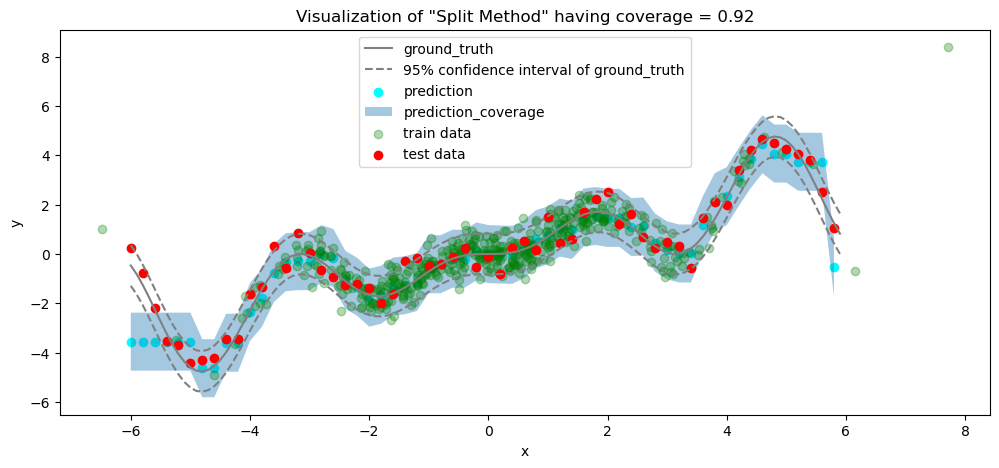

In [13]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_split,
    y_pred_interval=y_interval_split,
    method="Split Method"
)

(content:jackknife)=
## Jackknife Method

<div align="justify">

Instead of only using one calibration split to compute $l$ non-conformity scores as in the *Split Method* {ref}`split`, the Jackknife (or Leave-one-out) methods computes a $\alpha_i$ for each training point $i = 1, \dots, n$.
It consists of the following four steps:
1. For each training instance $i = 1, \dots, n$ fit a model $\hat{h}_{-i}$ on all data points excluding i.
2. Given $\hat{h}_{-i}$ the non-conformity scores are computed: $\alpha_i^{jack} = f_{\hat{h}_{-i}}(y_i,x_i)$ for each $i =1, \dots, n$.
3. Based on these scores $\alpha_1^{jack}, \dots, \alpha_{n}^{jack}$ the corresponding quantile $ q_{jack} =\lceil (1-\epsilon)*(n+1)\rceil \text{-quantile of the sequence }(\alpha_{1}^{jack},\alpha_{2}^{jack} \dots , \alpha_{n}^{jack})$ is calculated.
4. The prediction interval for a new instance $x_{n+1}$ is calculated through $\pm \ q_{jack}$:

$$
    [\hat{h}(x_{n+1}) - q_{jack} , \hat{h}(x_{n+1}) + q_{jack}]
$$

where $\hat{h}$ is the model trained on all $n$ data points.

Let us start with fitting the corresponding models $\hat{h}_{-i}$.
Doing this we can directly compute the corresponding $\alpha_i^{jack} = f_{\hat{h}_{-i}}(y_i,x_i)$.

</div>

In [14]:
model_missing_data = []
jackknife_non_conformity_scores = [0] * len(X_train)

# 1: Fit the \hat h_{-i} models on the training data
for i in range(len(X_train)):
    new_model = clone(base_model)
    
    X_train_missing_i, y_train_missing_i = np.delete(X_train, i, axis=0), np.delete(
        y_train, i, axis=0
    )
    new_model.fit(X_train_missing_i, y_train_missing_i)
    # 2: calculate non-conformity scores
    jackknife_non_conformity_scores[i] = np.abs(y_train[i] - new_model.predict(
        X_train[i].reshape(1, -1)
    ))
    model_missing_data.append(new_model)

jackknife_non_conformity_scores = np.array(jackknife_non_conformity_scores).ravel()

As for the next step we calculate the $\lceil (1-\epsilon)*(n+1)\rceil$-quantile of `jackknife_non_conformity_scores`.

In [15]:
# 3: Compute quantile
jackknife_quantile = calculate_quantile(jackknife_non_conformity_scores, epsilon)
jackknife_quantile

1.105269147909115

In the last step we train our model $\hat{h}$ on the entire $n$ data points. 
For a new data points $x_{n+1}$ the prediction interval $Y_\epsilon$ is computed by subtracting and adding the Quantile `jackknife_quantile` to $\hat{h}(x_{n+1})$.

In [16]:
# 4: Get prediction intervals
jackknife_model = clone(base_model)  # done such that upper cells do not interfere here
jackknife_model.fit(X_train, y_train)

jackknife_prediction, jackknife_interval = get_prediction_interval_through_quantile(
    jackknife_model.predict(X_test), jackknife_quantile
)
print(jackknife_interval[:2])
output_mean_interval_width(jackknife_interval)

[[-0.27175184  1.93878646]
 [-4.66435625 -2.45381795]]
Mean interval width:  2.21053829581823


Again as above in [Split]`content:split` we can firstly add the `jackknife_non_conformity_scores` to the prediction $\hat{h(x_{n+1})}$ and then take the corresponding Quantiles as bounds.

$$
    Y_\epsilon = [ q_{n,\epsilon}^{-}(\hat{h}(x_{n+1}) - \alpha_i^{jack}) \ , \ q_{n,\epsilon}^{+}(\hat{h}(x_{n+1}) + \alpha_i^{jack})]
$$

In [17]:
# 4
jackknife_model = clone(base_model)  # done such that upper cells do not interfere here
jackknife_model.fit(X_train, y_train)

jackknife_prediction_2, jackknife_interval_2 = get_prediction_interval_through_scores(
    jackknife_model.predict(X_test), jackknife_non_conformity_scores
)
print(jackknife_interval_2[:2])
output_mean_interval_width(jackknife_interval_2)

[[-0.27175184  1.93878646]
 [-4.66435625 -2.45381795]]
Mean interval width:  2.21053829581823


```{warning}
In most common cases the coverage of the jackknife method is equal to $1-\epsilon$.
But in scenarios where a regression model is less stable (samples size equal to number of features) the coverage might be less than $1-\epsilon$. For further details see {cite:t}`Barber2019PredictiveIW`.

```

Equally in MAPIE:

In [18]:
conformel_model = MapieRegressor(
    estimator=base_model, method="base", cv=-1, random_state=random_state
)
conformel_model.fit(X_train, y_train)

y_pred_jackknife, y_interval_jackknife = conformel_model.predict(X_test, alpha=epsilon)
y_interval_jackknife = y_interval_jackknife.reshape(-1, 2)

print(y_interval_jackknife[:2])
output_mean_interval_width(y_interval_jackknife)

[[-0.27175184  1.93878646]
 [-4.66435625 -2.45381795]]
Mean interval width:  2.21053829581823


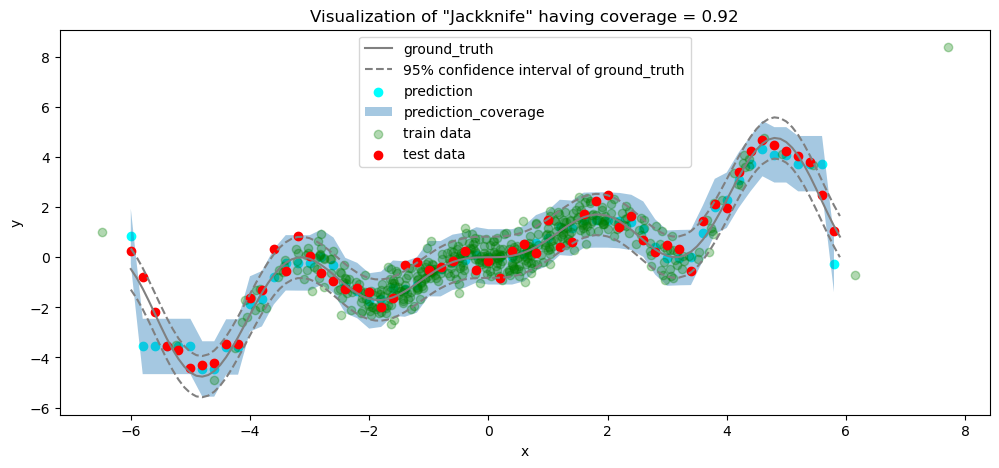

In [19]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_jackknife,
    y_pred_interval=y_interval_jackknife,
    method="Jackknife"
)

(content:jackknife_plus)=
## Jackknife+ Method

<div align="justify">


In Jackknife we build the intervals based on $\hat{h}(x_{N+1})$ and the non-conformity scores $\alpha_i^{jack}$.
As seen in our example it perform better than just using one split, but no theoretical guarantee on the coverage can be given (see {cite}`Barber2019PredictiveIW`).
We now introduce the Jackknife+ method proposed by {cite:t}`Barber2019PredictiveIW`. \
The prediction of $x_{n+1}$ is not only based on $\hat h$ but rather on multiple predictions $\hat{h}_{-1}, \dots , \hat{h}_{-n}$, incorporating the variability of the underlying machine learning algorithm.
Jackknife+ guarantees a coverage of at least $1-2\epsilon$ while not having any assumptions than exchangeablility.
We again distinguish four steps:
1. For each training instance $i = 1, \dots, n$ fit a model $\hat{h}_{-i}$ on all data points excluding i.
2. Given $i =1, \dots, n$ models $\hat{h}_{-i}$ the non-conformity scores are computed: $\alpha_i = y_i - \hat{h}_{-i}$.
3. Based on these scores $\alpha_1, \dots, \alpha_{n}$ the corresponding quantile $ q_{jack} =\lceil (1-\epsilon)*(n+1)\rceil \text{-quantile of the sequence }(\alpha_{1}, \, \alpha_{l+2}, \ldots , \alpha_{n})$ is calculated.
4. The prediction interval for a new instance $x_{n+1}$ is calculated through :

$$
    \left[q_{n,\epsilon}^{-}\left(\hat{h}_{-i}(x_{n+1}) - \alpha_i \right), \ q_{n,\epsilon}^{+}\left(\hat{h}_{-i}(x_{n+1}) + \alpha_i \right) \right]
$$

</div>

In [20]:
# 1: see above in chapter Jackknife
model_missing_data
# 2: see above in chapter Jackknife
jackknife_non_conformity_scores
# 3: get all predictions of the models \hat h_{-i}
missing_model_test_predictions = np.array([
    h_missing_i.predict(X_test) for h_missing_i in model_missing_data
]).T

# 4: build interval
jackknife_plus_prediction, jackknife_plus_interval = (
    get_prediction_interval_through_scores(
        missing_model_test_predictions, jackknife_non_conformity_scores
    )
)
print(jackknife_plus_interval[:2])
output_mean_interval_width(jackknife_plus_interval)

[[-0.26841832  1.94211998]
 [-4.65597107 -2.42719945]]
Mean interval width:  2.214530872034507


Again using the MAPIE package we can achieve the same:

In [21]:
mapie_jackknife_plus = MapieRegressor(
    estimator=base_model, method="plus", cv=-1, random_state=random_state
)
mapie_jackknife_plus.fit(X_train, y_train)

y_pred_jackknife_plus, y_interval_jackknife_plus = mapie_jackknife_plus.predict(X_test, alpha=epsilon)
y_interval_jackknife_plus = y_interval_jackknife_plus.reshape(-1, 2)

print(y_interval_jackknife_plus[:2])
output_mean_interval_width(y_interval_jackknife_plus)

[[-0.26841832  1.94211998]
 [-4.65597107 -2.42719945]]
Mean interval width:  2.214530872034507


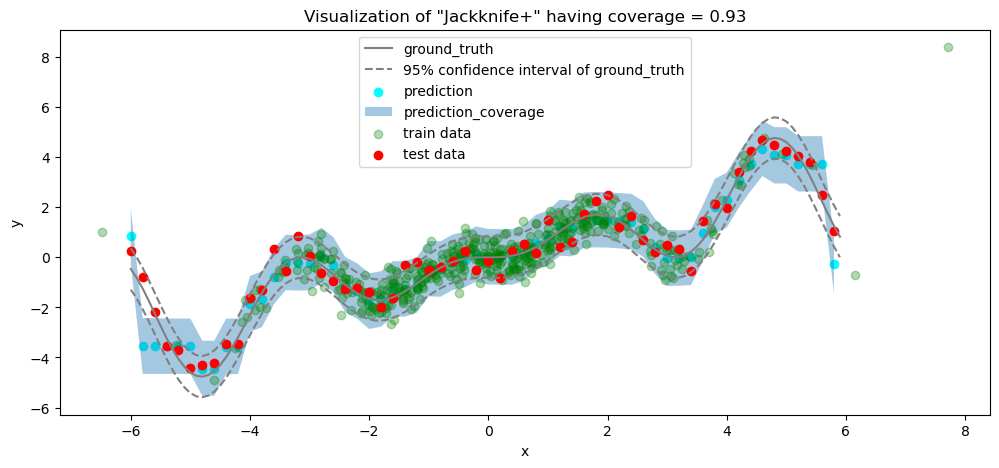

In [22]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_jackknife_plus,
    y_pred_interval=y_interval_jackknife_plus,
    method="Jackknife+"
)

(content:jacknife_plus_cv)=
## CV+ Method

<div align="justify">

While Jackknife and Jackknife+ improve the coverage of prediction sets, for increasing data points in gets very costly. Training a new model $\hat{h}_{-i}$ for each data point gets impractically for practical application. 
If we think of the amount of $\hat{h}_{-i}$ as a controllable parameter we arrive at the so called CV+ method.
It can again be expressed in five steps, only differing from Jackknife+ in the amount of $\hat{h}_{-i}$ models.
1. Split the training data $x_1, \dots, x_{n}$ into $m$ disjoint partitions $S_1, \dots, S_t$.
2. For each $j = 1, \dots, t$ train a model $\hat{h}_{-S_j}$ on all subsets excluding S_j.
3. Given $i =1, \dots, n$ training data points the non-conformity scores are computed: $\alpha_i = y_i - \hat{h}_{-S^i}$ where $S^i$ is the subset containing the data point $x_i$.
4. Based on these scores $\alpha_1, \dots, \alpha_{n}$ the corresponding quantile $ q_{cv+} =\lceil (1-\epsilon)*(n+1)\rceil \text{-quantile of the sequence }(\alpha_{1}, \, \alpha_{2}, \ldots , \alpha_{n})$ is calculated.
5. The prediction interval for a new instance $x_{n+1}$ is calculated through :
   
$$
    \left[q_{l+k,\epsilon}^{-}\left(\hat{h}_{-S^i}(x_{N+1}) - \alpha_i \right), \ q_{l+k,\epsilon}^{+}\left(\hat{h}_{-S^i}(x_{N+1}) + \alpha_i \right) \right]
$$

</div>


In [23]:
mapie_jackknife_plus_cv = MapieRegressor(
    estimator=base_model, method="plus", cv=10, random_state=random_state
)
mapie_jackknife_plus_cv.fit(X_train, y_train)

y_pred_jackknife_plus_cv, y_interval_jackknife_plus_cv = mapie_jackknife_plus_cv.predict(X_test, alpha=epsilon)
y_interval_jackknife_plus_cv = y_interval_jackknife_plus_cv.reshape(-1, 2)

print(y_interval_jackknife_plus_cv[:2])
output_mean_interval_width(y_interval_jackknife_plus_cv)

[[-3.9792325   1.94415344]
 [-4.53034491  1.27407775]]
Mean interval width:  2.566001402052204


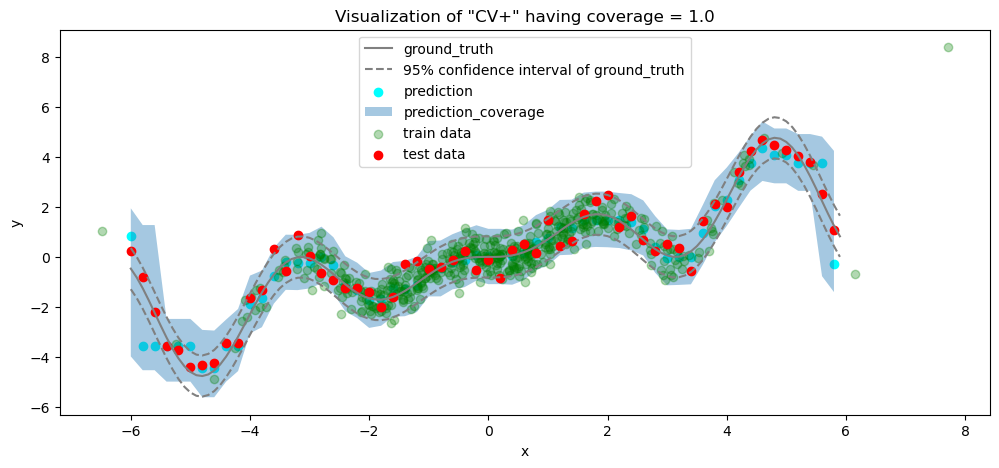

In [24]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_jackknife_plus_cv,
    y_pred_interval=y_interval_jackknife_plus_cv,
    method="CV+"
)

```{note}
A general advice when to use which method can be found [here](https://mapie.readthedocs.io/en/latest/theoretical_description_regression.html), alongside some more methods for heteroscedastic data or time series.
```

# Uncertainty Quantification in Conformal Regression
<div align="justify">

Quantifying the uncertainty of conformal regression outputs can intuitively be done by looking at the interval widths.
- The split method gives all intervals the same width, making it not very useful for individual uncertainty quantification.
- Similiarly Jackknife gives each point the same width, whilst much smaller.
- Incorporating the randomness of the regression model, Jackknife+ assigns each point a individual interval width. Thus making it more useful determining the uncertainty of the model for each point.
- Finally CV+ having fewer underlying $\hat h$ gives us also individual intervals, whilst being better in quantifying the uncertainty of points, where only few data points were seen.

</div>

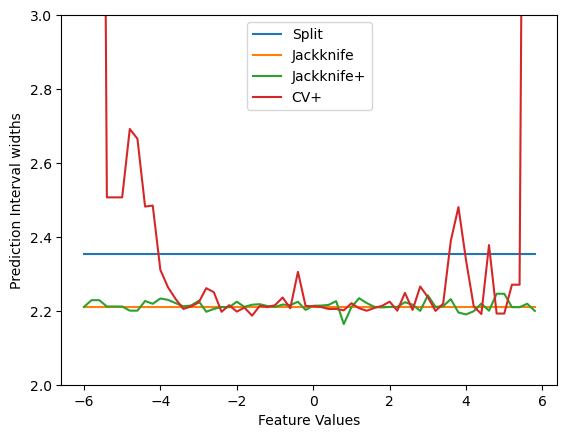

In [25]:
fig,ax = plt.subplots()

methods = ["Split","Jackknife","Jackknife+","CV+"]
intervals = [y_interval_split, y_interval_jackknife, y_interval_jackknife_plus, y_interval_jackknife_plus_cv]
methods_to_intervals = dict(zip(methods,intervals))

ax.set_ylim([2,3])
for method in methods:
    ax.plot(X_test, methods_to_intervals[method][:,1] - methods_to_intervals[method][:,0], label=method)

ax.set_xlabel("Feature Values")
ax.set_ylabel("Prediction Interval widths")
ax.legend()
plt.show()

